In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import keras
from keras.layers import Embedding, Dense, Input, MaxPooling1D, concatenate, Flatten, Dropout, BatchNormalization
from keras.layers import LSTM, Bidirectional, TimeDistributed
from keras.models import Model

In [24]:
train_df = pd.read_csv('/content/drive/MyDrive/Allstate Claims Severity/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Allstate Claims Severity/test.csv')
train_df.head(5)


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [25]:
train_df.shape

(188318, 132)

In [26]:
from sklearn.preprocessing import LabelEncoder
cat_cols = [x for x in train_df.columns if 'cat' in x]
cont_cols = [x for x in train_df.columns if 'cont' in x]
le_cat_encoder = LabelEncoder()
# fit the encoder based on training and test datasets
le_cat_encoder.fit(np.concatenate([train_df[x] for x in cat_cols]+
                                 [test_df[x] for x in cat_cols]))
print(len(le_cat_encoder.classes_), 'categories')
y_col = 'loss'

350 categories


In [27]:
all_emb_chan, all_inputs = [], []
for k in cat_cols:
    in_val = Input(shape = (1,), name = k)
    all_emb_chan +=[Embedding(len(le_cat_encoder.classes_)+1, 64)(in_val)]
    all_inputs += [in_val]
concat_layer = concatenate(all_emb_chan, axis = 1) # concatenate all of the columns together

norm_concat_emb = BatchNormalization()(concat_layer)
feature_layer = TimeDistributed(Dense(32))(Dropout(0.5)(norm_concat_emb))
feature_lstm = Bidirectional(LSTM(16))(feature_layer)

cont_input = Input(shape = (len(cont_cols),), name = 'continuous')
bn_cont = BatchNormalization()(cont_input)
cont_feature_layer = Dense(16)(Dropout(0.5)(bn_cont))
full_concat_layer = concatenate([feature_lstm, cont_feature_layer])
full_reduction = Dense(16)(full_concat_layer)

out_layer = Dense(1, activation = 'tanh')(full_reduction)
full_model = Model(inputs = all_inputs+[cont_input], 
                   outputs = [out_layer], name = 'FullModel')
full_model.compile(optimizer = 'adam', loss = 'mae')
print('Using a model with:', full_model.count_params(), 'parameters, in', len(full_model.layers), 'layers')

Using a model with: 2615529 parameters, in 244 layers


In [28]:
y_vec = train_df[y_col].copy().values
loss_mean, loss_std = y_vec.mean(), 3*y_vec.std()
y_vec -= loss_mean
y_vec /= loss_std
train_df['loss_norm'] = y_vec.clip(-1,1)

In [29]:
from sklearn.model_selection import train_test_split
t_split_df, v_split_df = train_test_split(train_df, 
                 test_size = 0.2,
                 stratify = pd.qcut(train_df['loss'], 10),
                                         random_state = 2017)
print(t_split_df.shape, v_split_df.shape)

(150654, 133) (37664, 133)


In [30]:
def gen_samples(in_df, batch_size = None, loss_name = 'loss_norm'):
    while True:
        out_df = in_df if batch_size is None else in_df.sample(batch_size)
        feed_dict = {c_name: le_cat_encoder.transform(out_df[c_name].values) for c_name in cat_cols}
        feed_dict['continuous'] = out_df[cont_cols].values
        yield feed_dict, out_df[loss_name].values

In [31]:
loss_history = []

In [32]:
for i in range(100):
    loss_history += [full_model.fit_generator(gen_samples(t_split_df, 32), 
                         steps_per_epoch = 250,
                         epochs = 1,
                         validation_data = next(gen_samples(v_split_df))
                         )]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


250/250 [==============================] - 50s 202ms/step - loss: 0.1302 - val_loss: 0.1276


In [33]:
%%time
valid_vars, valid_loss = next(gen_samples(v_split_df, loss_name = 'loss'))
pred_loss = full_model.predict(valid_vars).ravel()*loss_std+loss_mean

CPU times: user 36.2 s, sys: 864 ms, total: 37.1 s
Wall time: 22.8 s


Text(0.5, 0, 'Actual - Predicted Loss')

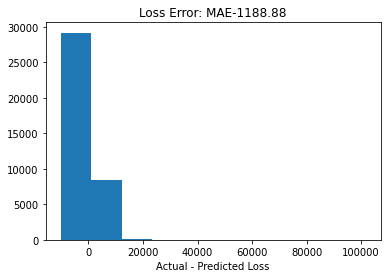

In [34]:
fig, ax1 = plt.subplots(1,1)
ax1.hist(valid_loss-pred_loss)
ax1.set_title('Loss Error: MAE-%2.2f' % (np.mean(np.abs(valid_loss-pred_loss))))
ax1.set_xlabel('Actual - Predicted Loss')

Make Prediction

In [35]:
%%time
test_vars, test_id = next(gen_samples(test_df, loss_name = 'id'))
pred_test_loss = full_model.predict(test_vars, verbose = 1).ravel()*loss_std+loss_mean

3924/3924 [==============================] - 117s 29ms/step
CPU times: user 2min 40s, sys: 3.63 s, total: 2min 44s
Wall time: 1min 59s


In [36]:
pd.DataFrame(dict(id = test_id, loss = pred_test_loss)).to_csv('/content/drive/MyDrive/Allstate Claims Severity/prediction.csv', index = False)